In [1]:
%run init_notebook.py

In [2]:
from src.utils import *
from src.processing import pd_join_dfs, pd_groupby, xcorr
from src.statsmodels import *
import scipy

In [3]:
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)

In [4]:
from src.utils import load_pd_df, save_pd_df, get_dt_index, pd_join_freq, Capturing, cross_corr, pd_df_astype, save_fig, get_stars
from src.processing import pd_groupby, pd_join_dfs, adf_test_summary, hausman, plt_stacked_bar, get_individual_perc_error
from src.pymc_modelling import get_samp

from statsmodels.stats.diagnostic import het_white, het_breuschpagan
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson

from linearmodels.panel import PanelOLS
from linearmodels import RandomEffects
from statsmodels.iolib.summary2 import summary_col

In [5]:
df_micro = load_pd_df("df_analysis_micro.feather", DATA_DIR)
df = load_pd_df("df_analysis.feather", DATA_DIR)

In [6]:
DICT_PARSE_COLS.update(
    {
        'T_pca_sum': float,
        'T_pca_sum_diff': float,
        'pi_de_surprise_Y': float,
        'pi_de_estimate_Y': float,
        'delta_pe_error': float,
        'hhinc_midpoint': 'categoryO',
        'T_sum_raw': float,
        'T_sum_glob': float,
        'T_sum_glob_op3': float,
        'T_sum_glob_op5': float,
        'T_sum_ind_op': float,
        'T_sum_ind_op_all': float,
        'T_sum_ind': float,
        'T_sum_raw_diff': float,
        'T_sum_glob_diff': float,
        'T_sum_ind_op_diff': float,
        'T_sum_ind_op_all_diff': float,
        'T_sum_ind_diff': float,
        'T_sum_glob_op3_diff': float,
        'T_sum_glob_op5_diff': float,
        'pi_de_Y_diff_F': float,
        'ecbtrust': float,
        'pi_de_Y_lead1': float,
        'pi_de_estimate_Y_lead1': float,
        'pi_de_surprise_Y_lead1': float,
        'month_recorded': "datetime64[ns]",
    }
)

In [7]:
df_micro = pd_df_astype(df_micro, DICT_PARSE_COLS)

## panel structure sparsity and distance analysis

In [8]:
filt = df_micro.groupby(['id', 'month_recorded']).pi_perc.last().unstack().count(axis=1)
filt.describe()

count    48684.000000
mean         1.550592
std          1.382918
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          8.000000
dtype: float64

In [9]:
sub = df_micro.set_index('id').loc[filt[filt > 1].index].reset_index().groupby(['id', 'month_recorded']).last()
sub = sub[
    ['hhinc_midpoint', 'pi_perc_error', 'delta_pe_error', 'debt', 'wealth_bank', 'savings_planned', 'ecbtrust', 'hhsize']
]

In [10]:
filt = sub.reset_index().groupby(['id', 'month_recorded']).delta_pe_error.last().unstack().count(axis=1)
# filt.describe()

In [11]:
dist = sub.reset_index().groupby('id').last().drop('month_recorded', axis=1).astype(float)
dist['distance'] = scipy.spatial.distance.cdist(dist.fillna(0).values, dist.fillna(0).values).mean(axis=0)
dist['distance'] = min_max_scale(dist.distance)

<AxesSubplot: xlabel='month_recorded'>

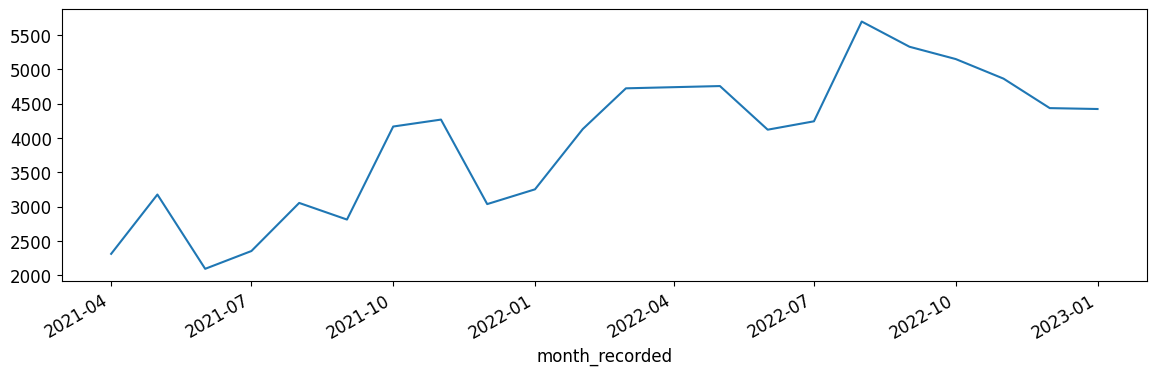

In [12]:
sub.reset_index().groupby('month_recorded').id.count().loc[datetime(2021,4,1):].plot()

In [13]:
sub = sub.loc[sub.index.get_level_values(1) >= datetime(2021,6,1)]

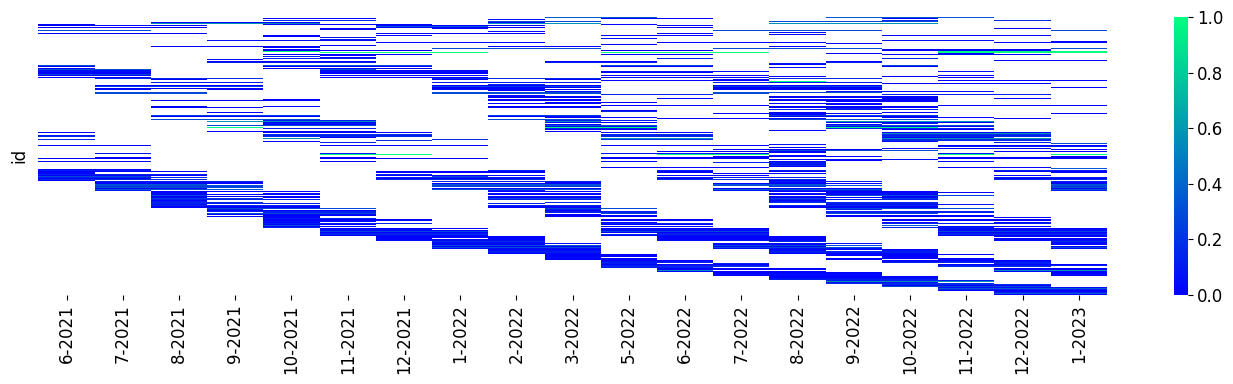

In [14]:
from matplotlib.dates import DateFormatter
myFmt = DateFormatter("%M-%Y")

fig, ax = get_fig_subplots()
_ = sub.reset_index().set_index('id').join(dist.distance).reset_index().set_index(['id', 'month_recorded']).distance.unstack()
_.columns = [str(x.month) + "-" + str(x.year) for x in _.columns]
sns.heatmap(
    _,
    cmap='winter',
    yticklabels=False,
    ax=ax
)
fig.tight_layout()
save_fig(fig, "panel_heatmap.png")

In [15]:
def pols_get_test_res(mod_fe, mod_re, sub, cols, sig: float = .05, seperator: str = "\n"):
    res = {}
    
    # H0: Homoscedasticity is present
    _ = sm.add_constant(pd.concat([mod_fe.resids, sub[cols]], axis=1))
    res['Breusch Pagan Test'] = dict(zip(
        ['LM-Stat', 'LM p-val', 'stat', 'pval'],
        het_breuschpagan(_[['residual']], _.drop('residual', axis=1))
    ))
    
    # Durbin watson
    res['Durbin-Watson Test'] = {'stat':durbin_watson(mod_fe.resids)}
    
    # Haussman H0: RE is to be preferred
    res['Hausmann Test'] = dict(zip(['stat', 'df', 'pval'], hausman(mod_fe, mod_re)))
    
    df = pd.DataFrame(res).T
    df['coef'] = df.pval <= sig
    df['star'] = df.pval.apply(lambda x: get_stars(float(x)))
    df['print'] = df.coef.astype(str) + " " + df.star.astype(str) + seperator + "[" + df.stat.round(3).astype(str) + "]"
    df.loc['Durbin-Watson Test', 'print'] = df.loc['Durbin-Watson Test', 'stat'].round(3).astype(str)
    
    return df

In [16]:
dict_fe_test_res = {}

## pi perc

In [17]:
cols = ['T_sum_ind_diff', 'pi_de_surprise_Y', 'pi_de_estimate_Y',] # 'hhinc_midpoint'] #, 'debt',]
ind_cols = ['id', 'month_recorded']
dep_col = ['pi_perc']
date_filt = datetime(2021,6,1)

In [18]:
df_micro = df_micro.set_index('date_recorded').loc[date_filt:].reset_index()

In [19]:
filt = df_micro.set_index('date_recorded').loc[date_filt:].groupby(ind_cols)[dep_col].last().dropna().unstack().count(axis=1)
# filt.describe()

In [20]:
i = 5
sub = df_micro.set_index('id').loc[filt[filt > i].index].reset_index().groupby(ind_cols).last()
sub = sub[cols + dep_col].dropna()

In [21]:
filt = sub.reset_index().groupby(ind_cols)[dep_col].last().unstack().count(axis=1)
# filt.describe()

In [22]:
sub.shape, filt.sum()

((1569, 4), 1569)

In [23]:
m_fe11 = PanelOLS(sub[dep_col], sub[cols], entity_effects=True, ).fit(cov_type='clustered', cluster_entity=True)
m_re11 = RandomEffects(sub[dep_col], sub[cols]).fit()

In [24]:
dist, filt = get_cooks_distance(sub[cols].values.astype(float), m_fe11.resids.values, flt_largest_perc=95.)
sub2 = sub.drop(sub.loc[filt].index.get_level_values(0))
m_fe1_ = PanelOLS(sub2[dep_col], sub2[cols],
                   entity_effects=True, drop_absorbed=True, check_rank=False).fit(cov_type="clustered", cluster_entity=True)

In [25]:
out = get_statsmodels_summary([m_fe11, m_fe1_], ['print'], seperator=" ", is_filt_sig=False)
# out

In [26]:
name, i = dep_col[0], 1
while (name in dict_fe_test_res.keys()) == True:
    name += str(i)
dict_fe_test_res[name] = pols_get_test_res(m_fe11, m_re11, sub, cols)['print']

## pi perc 2

In [27]:
cols = ['T_sum_ind_diff', 'pi_de_surprise_Y_lead1', 'pi_de_estimate_Y_lead1'] #, 'debt',]
ind_cols = ['id', 'month_recorded']
dep_col = ['pi_perc']

In [28]:
filt = df_micro.set_index('date_recorded').loc[date_filt:].groupby(ind_cols)[dep_col].last().dropna().unstack().count(axis=1)
# filt.describe()

In [29]:
i = 5
sub = df_micro.set_index('id').loc[filt[filt > i].index].reset_index().groupby(ind_cols).last()
sub = sub[cols + dep_col].dropna()

In [30]:
filt = sub.reset_index().groupby(ind_cols)[dep_col].last().unstack().count(axis=1)
# filt.describe()

In [31]:
sub.shape, filt.sum()

((1569, 4), 1569)

In [32]:
m_fe12 = PanelOLS(sub[dep_col], sub[cols], entity_effects=True, ).fit(cov_type='clustered', cluster_entity=True)
m_re = RandomEffects(sub[dep_col], sub[cols]).fit()

In [33]:
dist, filt = get_cooks_distance(sub[cols].values.astype(float), m_fe12.resids.values, flt_largest_perc=90.)
sub2 = sub.drop(sub.loc[filt].index.get_level_values(0))
m_fe_ = PanelOLS(sub2[dep_col], sub2[cols],
                   entity_effects=True, drop_absorbed=True, check_rank=False).fit(cov_type="clustered", cluster_entity=True)

In [34]:
out = get_statsmodels_summary([m_fe12, m_fe_], ['print'], seperator=" ", is_filt_sig=False)
# out

In [35]:
name, i = dep_col[0], 1
while (name in dict_fe_test_res.keys()) == True:
    name += str(i)
dict_fe_test_res[name] = pols_get_test_res(m_fe12, m_re, sub, cols)['print']

## delta pe 1

In [36]:
cols = ['T_sum_ind_diff', 'hhinc_midpoint', 'pi_de_surprise_Y', 'pi_de_estimate_Y', 'is_unempl'] #, 'is_unempl', 'wealth_bank',]  #'debt',]
ind_cols = ['id', 'month_recorded']
dep_col = ['delta_pe']

In [37]:
filt = df_micro.set_index('date_recorded').loc[date_filt:].groupby(ind_cols)[dep_col].last().dropna().unstack().count(axis=1)
# filt.describe()

In [38]:
i = 10
sub = df_micro.set_index('id').loc[filt[filt > i].index].reset_index().groupby(ind_cols).last()
sub = sub[cols + dep_col].dropna()

In [39]:
filt = sub.reset_index().groupby(ind_cols)[dep_col].last().unstack().count(axis=1)
# filt.describe()

In [40]:
sub.shape, filt.sum()

((3830, 6), 3830)

In [41]:
m_fe2 = PanelOLS(sub[dep_col], sub[cols], entity_effects=True).fit(cov_type='robust', cluster_entity=False)
m_re2 = RandomEffects(sub[dep_col], sub[cols]).fit(cov_type='robust')

In [42]:
name, i = dep_col[0], 1
while (name in dict_fe_test_res.keys()) == True:
    name += str(i)
dict_fe_test_res[name] = pols_get_test_res(m_fe2, m_re2, sub, cols)['print']

In [43]:
pols_get_test_res(m_fe2, m_re2, sub, cols)

,LM-Stat,LM p-val,stat,pval,df,coef,star,print
Breusch Pagan Test,808.842967,1.413209e-172,204.757017,6.347224e-194,NaN,True,***,True ***\n[204.757]
Durbin-Watson Test,NaN,NaN,1.591697,NaN,NaN,False,,1.592
Hausmann Test,NaN,NaN,97.742423,9.160921e-14,16.0,True,***,True ***\n[97.742]


## pi perc resid

In [84]:
cols = ['T_sum_ind_diff', 'pi_de_surprise_Y', 'pi_de_estimate_Y', 'is_unempl' ] #'debt', 'is_unempl', 'wealth_bank',]  #'debt',]
ind_cols = ['id', 'month_recorded']
dep_col = ['pi_perc_error']

In [85]:
filt = df_micro.set_index('date_recorded').loc[date_filt:].groupby(ind_cols)[dep_col].last().dropna().unstack().count(axis=1)
# filt.describe()

In [90]:
i = 5
sub = df_micro.set_index('id').loc[filt[filt > i].index].reset_index().groupby(ind_cols).last()
sub = sub[cols + dep_col].dropna()

In [91]:
filt = sub.reset_index().groupby(ind_cols)[dep_col].last().unstack().count(axis=1)
# filt.describe()

In [92]:
sub.shape, filt.sum()

((105, 5), 105)

In [112]:
m_fe41 = PanelOLS(sub[dep_col], sub[cols], entity_effects=True)
m_fe41 = m_fe41.fit(cov_type='homoskedastic', )
m_re4 = RandomEffects(sub[dep_col], sub[cols]).fit()
# m_fe4.summary

In [113]:
name, i = dep_col[0], 1
while (name in dict_fe_test_res.keys()) == True:
    name += str(i)
dict_fe_test_res[name] = pols_get_test_res(m_fe41, m_re4, sub, cols)['print']

In [114]:
pols_get_test_res(m_fe41, m_re4, sub, cols)

,LM-Stat,LM p-val,stat,pval,df,coef,star,print
Breusch Pagan Test,2.051678,0.726254,0.498230,0.737060,NaN,False,,False \n[0.498]
Durbin-Watson Test,NaN,NaN,1.948641,NaN,NaN,False,,1.949
Hausmann Test,NaN,NaN,1.332111,0.855904,4.0,False,,False \n[1.332]


## delta pe resid

In [51]:
cols = ['T_sum_ind_diff', 'pi_de_surprise_Y', 'pi_de_estimate_Y', 'hhinc_midpoint', 'is_unempl', ] #'wealth_bank',]  #'debt',]
ind_cols = ['id', 'month_recorded']
dep_col = ['delta_pe_error']

In [52]:
filt = df_micro.set_index('date_recorded').loc[date_filt:].groupby(ind_cols)[dep_col].last().dropna().unstack().count(axis=1)
filt.describe()

count    27558.000000
mean         3.368169
std          2.827147
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max         11.000000
dtype: float64

In [53]:
i = 9
sub = df_micro.set_index('id').loc[filt[filt > i].index].reset_index().groupby(ind_cols).last()
sub = sub[cols + dep_col].dropna()

In [54]:
filt = sub.reset_index().groupby(ind_cols)[dep_col].last().unstack().count(axis=1)
filt.describe()

count    703.000000
mean      10.337127
std        1.168863
min        1.000000
25%       10.000000
50%       10.000000
75%       11.000000
max       11.000000
dtype: float64

In [55]:
sub.shape, filt.sum()

((7267, 6), 7267)

In [57]:
m_fe5 = PanelOLS(sub[dep_col], sub[cols], entity_effects=True).fit(cov_type='clustered', cluster_entity=True)
m_re = RandomEffects(sub[dep_col], sub[cols]).fit()
# print(m_fe5)

In [58]:
name, i = dep_col[0], 1
while (name in dict_fe_test_res.keys()) == True:
    name += str(i)
dict_fe_test_res[name] = pols_get_test_res(m_fe5, m_re, sub, cols)['print']

## summary

In [64]:
lst_fes = [m_fe11, m_fe12, m_fe2, m_fe41, m_fe5]
out = get_statsmodels_summary(lst_fes, seperator="\n", is_filt_sig=True)
save_pd_df(out, 'tab_pols.csv', GRAPHS_DIR)

out2 = get_statsmodels_summary(lst_fes, seperator=" ", is_filt_sig=False)
save_pd_df(out2, 'tab_pols_all.csv', GRAPHS_DIR)

In [66]:
out.sort_index(ascending=False)

,delta_pe,delta_pe_error,pi_perc,pi_perc_1,pi_perc_error
pi_de_surprise_Y,-0.616 ***\n[-52.676],-0.93 ***\n[-67.408],-0.201 *\n[-1.824],NaN,-0.489 ***\n[-4.696]
pi_de_estimate_Y_lead1,NaN,NaN,NaN,1.304 ***\n[37.436],NaN
pi_de_estimate_Y,0.478 ***\n[54.886],3.529 ***\n[428.688],1.417 ***\n[30.254],NaN,-0.053 \n[-1.153]
is_unempl,-0.002 \n[-1.255],0.004 \n[1.162],NaN,NaN,-0.009 **\n[-2.527]
hhinc_midpoint.12000.0,0.001 \n[0.429],-0.013 ***\n[-2.606],NaN,NaN,NaN
T_sum_ind_diff,0.044 ***\n[9.097],-0.103 ***\n[-38.355],0.018 \n[1.096],-0.003 \n[-0.242],0.045 **\n[2.473]
R^2 between,0.761,-57.556,0.933,0.914,0.422
R^2,0.392,0.906,0.659,0.675,0.06
N time,15.0,17.0,13.0,13.0,13.0
N entity,353.0,703.0,259.0,259.0,259.0


In [61]:
out = pd.DataFrame(dict_fe_test_res).T.sort_index()
save_pd_df(out, 'tab_pols_tests.csv', GRAPHS_DIR)

In [62]:
out

,Breusch Pagan Test,Durbin-Watson Test,Hausmann Test
delta_pe,True ***\n[204.757],1.592,True ***\n[97.742]
delta_pe_error,True ***\n[573.451],1.155,True ***\n[43.84]
pi_perc,False \n[1.413],1.999,True ***\n[14.876]
pi_perc1,False \n[0.968],2.001,True ***\n[46.493]
pi_perc_error,False *\n[2.022],2.033,False \n[4.473]
